In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

In [12]:
# Create an inspector object and read column names and types 

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [15]:
print(dt.date(2023,1,1))

2023-01-01


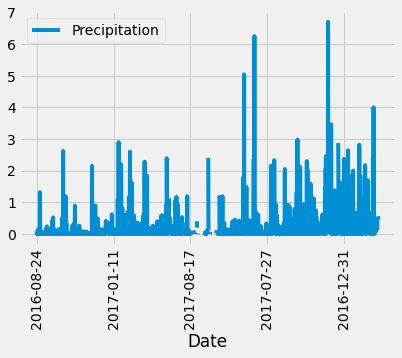

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_prior = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores



# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > year_prior).all()
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
df.sort_values(by="Date") 
df.reset_index()
df.dropna(how='any')
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(x='Date', y='Precipitation')
plt.xticks(rotation=90)
plt.show()

In [17]:
quartiles = df['Precipitation'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
keys = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']


count = df['Precipitation'].count()
mean = df['Precipitation'].mean()
std = df['Precipitation'].std()
dfmin = df['Precipitation'].min()
twenty5 = lowerq
median = df['Precipitation'].median()
seventy5 = upperq
dfmax = df['Precipitation'].max()
values = [count,mean,std,dfmin,twenty5,median,seventy5,dfmax]
print(values)

[2015, 0.1764615384615388, 0.46028836368132586, 0.0, 0.0, 0.02, 0.13, 6.7]


In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_df = pd.DataFrame(values,index=keys, columns=['value'])
sum_df

,value
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
data = session.query(Station)
for row in data:
    print(row.id, row.station,row.name,row.latitude,row.longitude,row.elevation)

1 USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0
2 USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0
4 USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9
5 USC00518838 UPPER WAHIAWA 874.3, HI US 21.4992 -158.0111 306.6
6 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5
7 USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9
8 USC00511918 HONOLULU OBSERVATORY 702.2, HI US 21.3152 -157.9992 0.9
9 USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4


In [20]:
station_columns = inspector.get_columns('station')
for col in station_columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Station.station, func.count(Measurement.station)).filter(Station.station == Measurement.station).group_by(Station.station).all()


[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Station.station, func.count(Measurement.station)).filter(Station.station == Measurement.station).group_by(Station.station).order_by(desc(func.count(Measurement.station))).first()

highest_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active.station).order_by(Measurement.tobs.desc()).first()
lowest_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active.station).order_by(Measurement.tobs.asc()).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active.station).first()

print(highest_temp, lowest_temp, avg_temp)


(85.0,) (54.0,) (71.66378066378067,)


In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date_most_active = session.query(Measurement.date).filter(Measurement.station == most_active.station).order_by(Measurement.date.desc()).first()

print(last_date_most_active)

('2017-08-18',)


<AxesSubplot:ylabel='Frequency'>

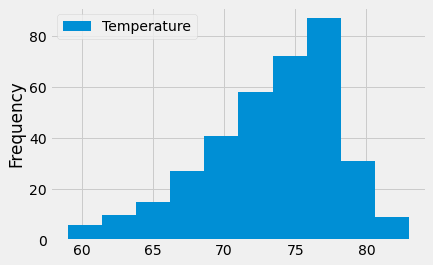

In [79]:
year_prior_most_active = dt.date(2017,8,18) - dt.timedelta(days=365)


data_two = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active.station).filter(Measurement.date > year_prior_most_active).all()

data_two

df_two = pd.DataFrame(data_two, columns=['Date', 'Temperature'])
df_two.sort_values('Date')


df_two.plot(kind='hist',xlabel='Temperature')



# Close Session

In [16]:
# Close Session
session.close()